In [2]:
import os
import pathlib
import random
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Num GPUs Available:  1


In [ ]:
import kagglehub

path = kagglehub.dataset_download("aadarshvelu/gym-equipements-classification/versions/1")

print("Path to dataset files:", path)

100%|██████████| 31.8M/31.8M [00:02<00:00, 11.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aadarshvelu/gym-equipements-classification/versions/1


In [1]:
!unzip Gym\ Dataset\ Cropped.zip -d dataset

Archive:  Gym Dataset Cropped.zip
   creating: dataset/Gym Dataset Cropped/
   creating: dataset/Gym Dataset Cropped/Smith Machine/
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (20).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/signatureseries-benches-racks-smith-machine-l-data.png  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (19).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/6110ffa7-4842-4a33-84e0-66134cfd83e7.jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (2).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (10).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (4).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (15).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (9).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/images (8).jpg  
  inflating: dataset/Gym Dataset Cropped/Smith Machine/smith-machine-pre-order

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/aadarshvelu/gym-equipements-classification/versions/1/gym_equipments_classification /content/

In [3]:
basepath = pathlib.Path("/content/dataset/Gym Dataset Cropped")
labels = os.listdir(basepath)
len(labels), labels

(7,
 ['Recumbent Bike',
  'Dumbells',
  'Elliptical Machine',
  'Stair Climber',
  'Treadmill',
  'Bench Press',
  'Smith Machine'])

In [4]:
target_shape = (299, 299)

In [5]:
x, y = [], []
for idx, label in enumerate(labels):
    for image_path in basepath.glob(f"{label}/*"):
        image = cv.imread(str(image_path))
        image = cv.resize(image, target_shape)
        x.append(image)
        y.append(idx)

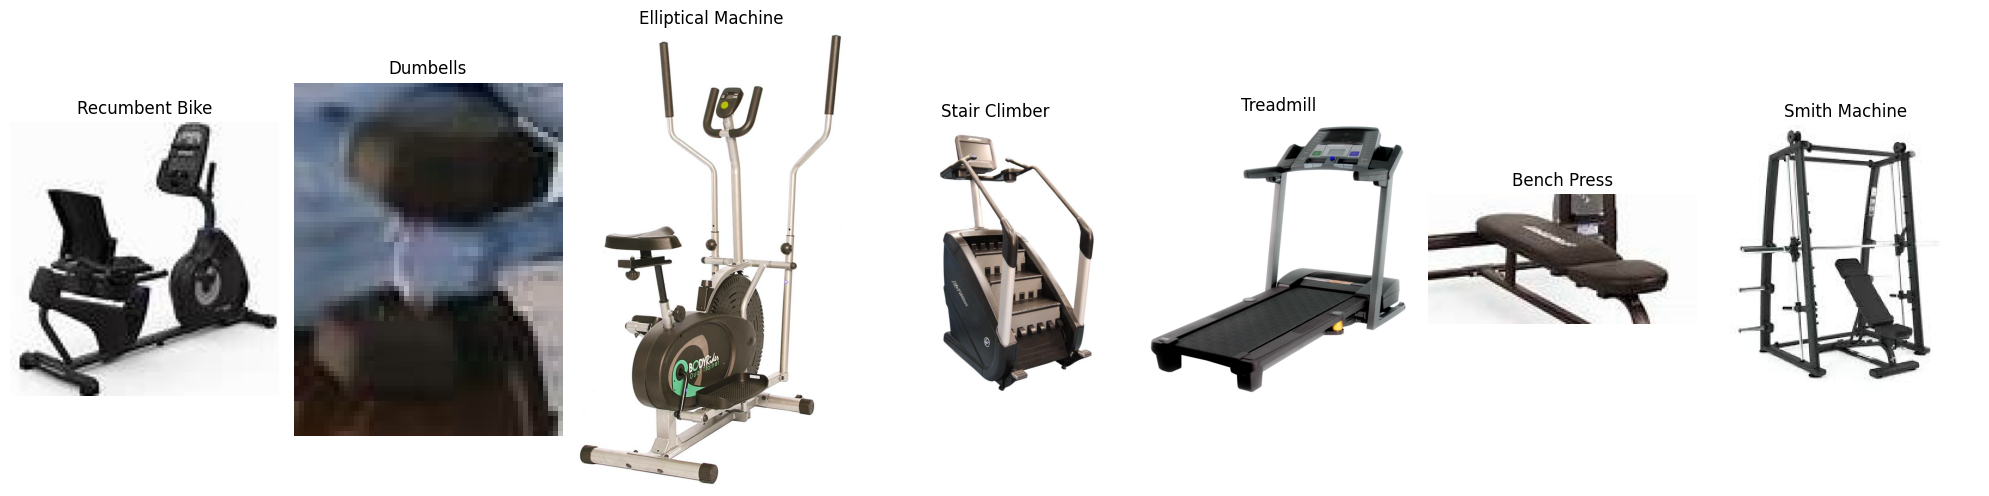

In [7]:
fig, ax = plt.subplots(1, 7, figsize=(20, 5))

ax = ax.flatten()

for idx, label in enumerate(labels):
    ax[idx].imshow(cv.imread(str(list(basepath.glob(f"{label}/*"))[random.randint(0, 30)])))
    ax[idx].set_title(label)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

<Axes: ylabel='count'>

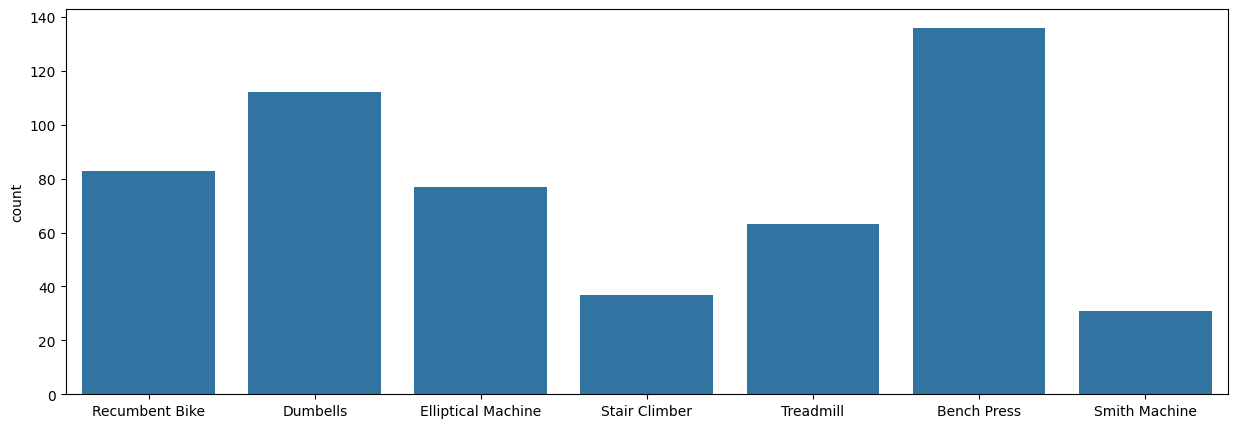

In [8]:
plt.subplots(figsize=(15, 5))

sns.countplot(x=[labels[i] for i in y])

In [9]:
@tf.function
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image.set_shape((299, 299, 3))
    return image, label

def balance_dataset(dataset, target_bal, labels):
    augmented_datasets = []
    for label in range(len(labels)):
        label_dataset = dataset.filter(lambda img, lbl: tf.equal(lbl, label))
        label_count = sum(1 for _ in label_dataset)
        print(f"Label {label}: Found {label_count} samples")

        if label_count < target_bal:
            repeat_count = (target_bal - label_count) // label_count
            remainder = (target_bal - label_count) % label_count
            print(f"Label {label}: Augmenting {repeat_count * label_count + remainder} samples")

            augmented_label_dataset = label_dataset.map(augment_image)
            augmented_label_dataset = augmented_label_dataset.repeat(repeat_count).take(remainder)
            full_label_dataset = label_dataset.concatenate(augmented_label_dataset)
        else:
            full_label_dataset = label_dataset.take(target_bal)

        augmented_datasets.append(full_label_dataset)

    balanced_dataset = tf.data.Dataset.sample_from_datasets(augmented_datasets)
    return balanced_dataset

initial_dataset = tf.data.Dataset.from_tensor_slices((x, y))
balanced_dataset = balance_dataset(initial_dataset, target_bal=200, labels=labels)
balanced_dataset = balanced_dataset.shuffle(200).batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
unbatched_dataset = balanced_dataset.unbatch()

total_data_count = sum(1 for _ in unbatched_dataset)
train_size = int(0.9 * total_data_count)

train_dataset = unbatched_dataset.take(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = unbatched_dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)

Label 0: Found 83 samples
Label 0: Augmenting 117 samples
Label 1: Found 112 samples
Label 1: Augmenting 88 samples
Label 2: Found 77 samples
Label 2: Augmenting 123 samples
Label 3: Found 37 samples
Label 3: Augmenting 163 samples
Label 4: Found 63 samples
Label 4: Augmenting 137 samples
Label 5: Found 136 samples
Label 5: Augmenting 64 samples
Label 6: Found 31 samples
Label 6: Augmenting 169 samples


Label distribution after augmentation: Counter({5: 129, 2: 121, 0: 110, 1: 109, 4: 74, 3: 52, 6: 45})


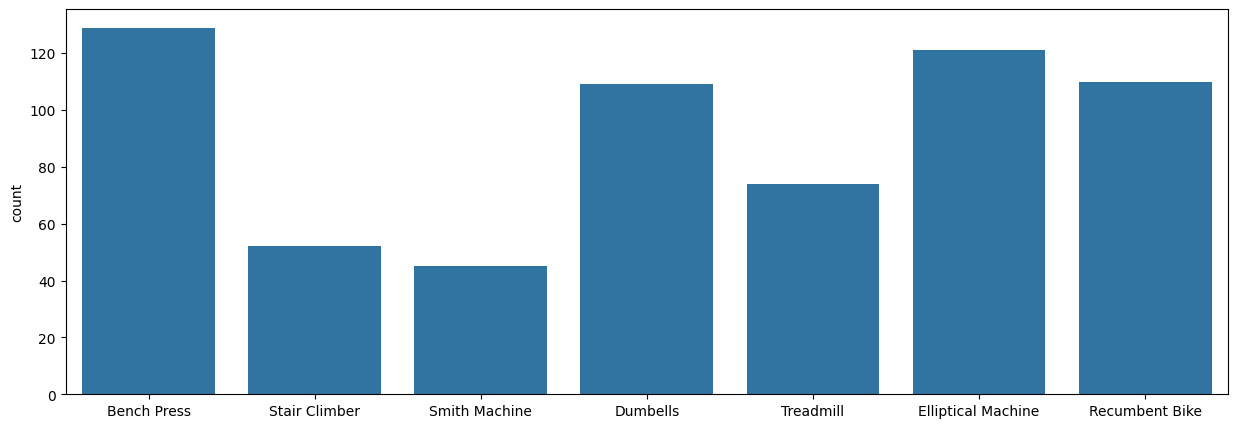

In [10]:
y_augmented = []
for _, label in balanced_dataset.unbatch():
    y_augmented.append(label.numpy())

plt.figure(figsize=(15, 5))
sns.countplot(x=[labels[i] for i in y_augmented])
from collections import Counter
label_counts = Counter(y_augmented)
print("Label distribution after augmentation:", label_counts)

In [11]:
print(f"Total data: {total_data_count}")
print(f"Train data: {sum(1 for _ in train_dataset.unbatch())}")
print(f"Test data: {sum(1 for _ in test_dataset.unbatch())}")

Total data: 640
Train data: 576
Test data: 64


In [12]:
xtn = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

for layer in xtn.layers[-20:]:
    layer.trainable = True

model = Sequential([
    xtn,
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
optimizer= Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
steps_per_epoch = len(x) // 32
validation_steps = len(y) // 32

In [15]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=test_dataset,
)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5478 - loss: 1.1620 - val_accuracy: 0.5938 - val_loss: 1.2011
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9102 - loss: 0.3224 - val_accuracy: 0.7188 - val_loss: 0.8378
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 970ms/step - accuracy: 0.8876 - loss: 0.4392 - val_accuracy: 0.7500 - val_loss: 2.5526
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9854 - loss: 0.1311 - val_accuracy: 0.8281 - val_loss: 2.0755
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 948ms/step - accuracy: 0.9290 - loss: 0.2176 - val_accuracy: 0.6250 - val_loss: 5.2072
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9521 - loss: 0.2454 - val_accuracy: 0.6094 - val_loss: 5.6051
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 924ms/step - accuracy: 0.9442 - loss: 0.2437 - val_accuracy: 0.5312 - val_loss: 16.7173
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9189 - loss: 0.2119 - val_accuracy: 0.4688 - val_loss: 19.4696
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 908ms/step - accuracy: 0.9241 - loss: 0.2131 - val_accuracy: 0.5469 

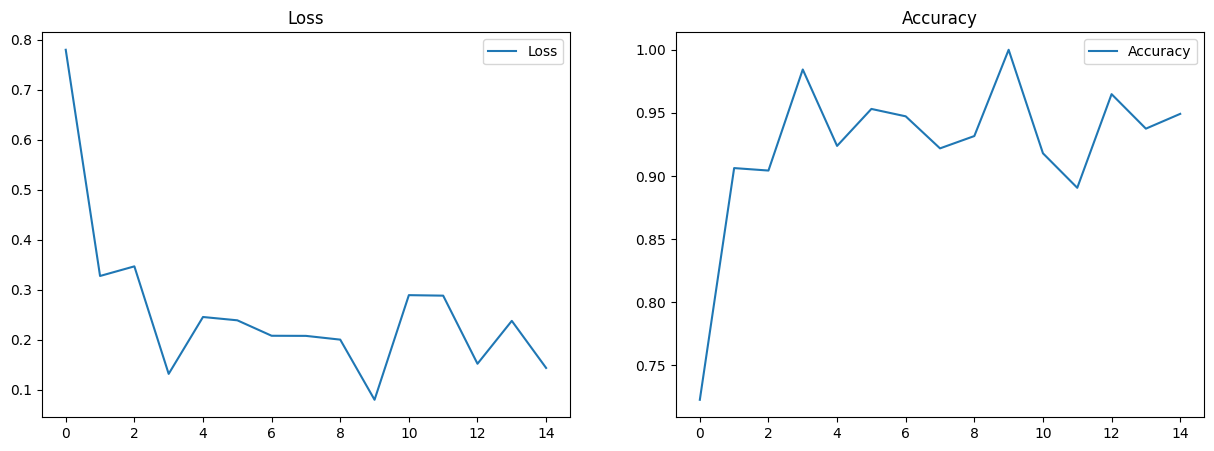

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.9062 - loss: 0.8538
Test Accuracy: 0.90625
Test Loss: 0.8151334524154663


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


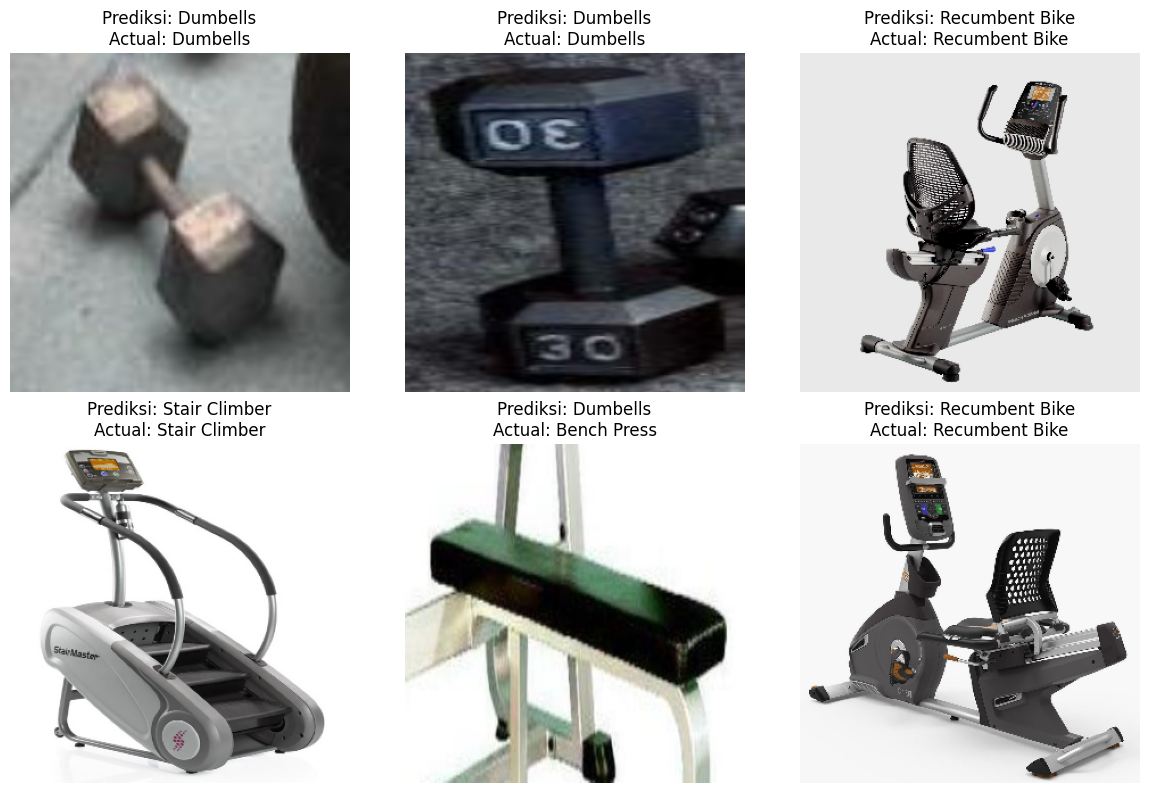

In [19]:
import numpy as np

sample_images, sample_labels = next(iter(test_dataset))

predictions = model.predict(sample_images)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    predicted_label = np.argmax(predictions[i])
    actual_label = sample_labels[i].numpy()

    axes[i].imshow(sample_images[i].numpy().astype("uint8"))
    axes[i].set_title(
        f"Prediksi: {labels[predicted_label]}\nActual: {labels[actual_label]}"
    )
    axes[i].axis('off')

for j in range(6, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()